# [ Going Deeper(CV) ] 12. 직접 만들어보는 OCR

✅정의

---
### - 📖목차
* ✔️12-9. 프로젝트: End-to-End OCR
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️12-9. 프로젝트: End-to-End OCR
---
### 라이브러리 버전 확인


In [ ]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import re
import six
import math
import lmdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import keras_ocr

In [ ]:
import os

path = "/content/gdrive/MyDrive/aiffel/gd_12"

os.chdir(path)

print(path)

/content/gdrive/MyDrive/aiffel/gd_12


In [ ]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [ ]:
BATCH_SIZE = 128
HOME_DIR = '/content/gdrive/MyDrive/aiffel/gd_12'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/content/gdrive/MyDrive/aiffel/gd_12/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


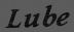

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


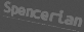

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


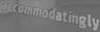

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


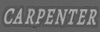

In [ ]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [ ]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                dataset_path,
                label_converter,
                batch_size=1,
                img_size=(100,32),
                max_text_len=22,
                is_train=False,
                character='') :
        
        self.label_converter = label_converter  # 문자를 미리 정의된 index로 변환해주는 converter
        self.batch_size = batch_size  # 배치 사이즈
        self.img_size = img_size  # 입력 이미지 크기
        self.max_text_len = max_text_len  # 최대 글자 수
        self.character = character  # 학습 대상으로 한정하기 위한 character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다

    # - 이미지 데이터를 img, label 의 쌍으로 가져오는 메서드
    # => 다양한 사이즈의 이미지를 모두 height 는 32, width 는 최대 100 이 되도록 가공
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__

    # - model.fit() 에서 호출되는 메서드: 배치 단위만큼 _get_img_label()을 통해 가져온 데이터셋 리턴
    def __getitem__(self, idx):
        # 1. idx에 해당하는 index_list만큼 데이터를 불러
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2. image와 label을 불러오고 
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [ ]:
class LabelConverter(object):

    # 입력으로 받은 text를 self.dict 에 각 character 들이 어떤 index 에 매핑되는지 저장
    # => character, index 를 통해 모델이 학습할 수 있는 output 이 생성됨
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    # character -> index 변환
    # cf. 공백 문자를 뜻하는 '-' 의 label 은 0 으로 지정
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백(blank) 문자 label을 삽입
            encoded_label.append(self.label_map[char])

        return np.array(encoded_label)

    # index -> character 변환
    # => 사람이 읽을 수 있는 text 로 변경
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [ ]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)  # [ 8  5 12  0 12 15]
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)  # HEL-LO

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [ ]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [ ]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

<br>

-----
### 3. 모델 훈련하기

In [ ]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
EPOCHS=50

# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = os.path.join(DATA_DIR, f'model_checkpoint_{EPOCHS}.hdf5')
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
crnn_history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=EPOCHS,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[ckp, earlystop]
)

Epoch 1/50
565/565 [==============================] - ETA: 0s - loss: 25.8560 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 26.20568, saving model to ocr/data\model_checkpoint_50.hdf5
565/565 [==============================] - 122s 195ms/step - loss: 25.8560 - accuracy: 0.0000e+00 - val_loss: 26.2057 - val_accuracy: 0.0000e+00
Epoch 2/50
565/565 [==============================] - ETA: 0s - loss: 18.8072 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 26.20568 to 13.10028, saving model to ocr/data\model_checkpoint_50.hdf5
565/565 [==============================] - 112s 198ms/step - loss: 18.8072 - accuracy: 0.0000e+00 - val_loss: 13.1003 - val_accuracy: 0.0000e+00
Epoch 3/50
565/565 [==============================] - ETA: 0s - loss: 8.6842 - accuracy: 0.0287
Epoch 00003: val_loss improved from 13.10028 to 7.62177, saving model to ocr/data\model_checkpoint_50.hdf5
565/565 [==============================] - 111s 197ms/step - loss: 8.6842 - accuracy: 0.0287 -

In [ ]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

<br>

-----
### 4. 훈련 과정 시각화하기

In [ ]:
def draw_unet_history(history, model_name='Recognition_CRNN'):
    plt.subplots(figsize=(12,4))

    # Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f'result/{model_name}_Result.png')  # 저장
    plt.show()

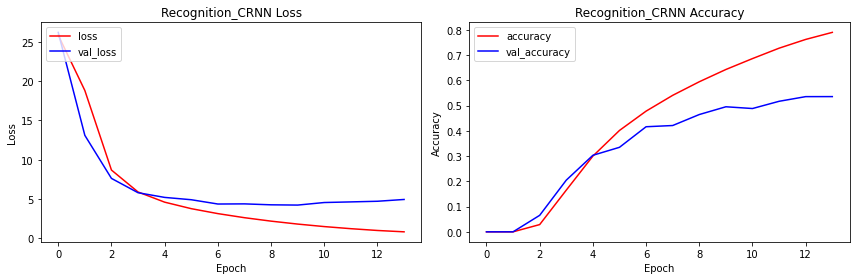

In [ ]:
draw_unet_history(crnn_history, 'Recognition_CRNN')

Result: 	 SLINKING


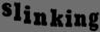

Result: 	 ALEPPO


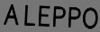

Result: 	 FWSNDE


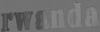

Result: 	 NATHANS


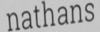

Result: 	 HAILLO


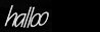

Result: 	 HURLS


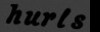

Result: 	 DOWNSIZE


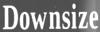

Result: 	 ROBOTIC


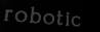

Result: 	 SLOPPY


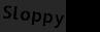

Result: 	 HERMITE


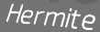

Result: 	 DEARS


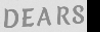

Result: 	 POLYSYLLABIC


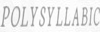

Result: 	 DETRA


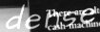

Result: 	 DIAERESES


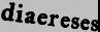

Result: 	 HUMPBACKS


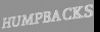

Result: 	 MOPTED


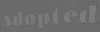

Result: 	 NILWAUKEE


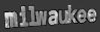

Result: 	 SPECIFICATION


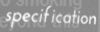

Result: 	 REACTIONARY


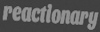

Result: 	 OSCEOLA


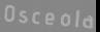

In [ ]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=20)

In [ ]:
def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result_img = img.copy()
    result_img = result_img.astype('uint8')
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        x_min = int(text_result[:,0].min() - 5)
        x_max = int(text_result[:,0].max() + 5)
        y_min = int(text_result[:,1].min() - 5)
        y_max = int(text_result[:,1].max() + 5)
        cropped_imgs.append(img[y_min:y_max,x_min:x_max])
        
        for i in range(4):
            if i<3:
                result_img = cv2.line(result_img,tuple(map(int,text_result[i])),tuple(map(int,text_result[i+1])),(255,0,0),3)
            else:
                result_img = cv2.line(result_img,tuple(map(int,text_result[3])),tuple(map(int,text_result[0])),(255,0,0),3)
    return result_img, cropped_imgs

In [ ]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


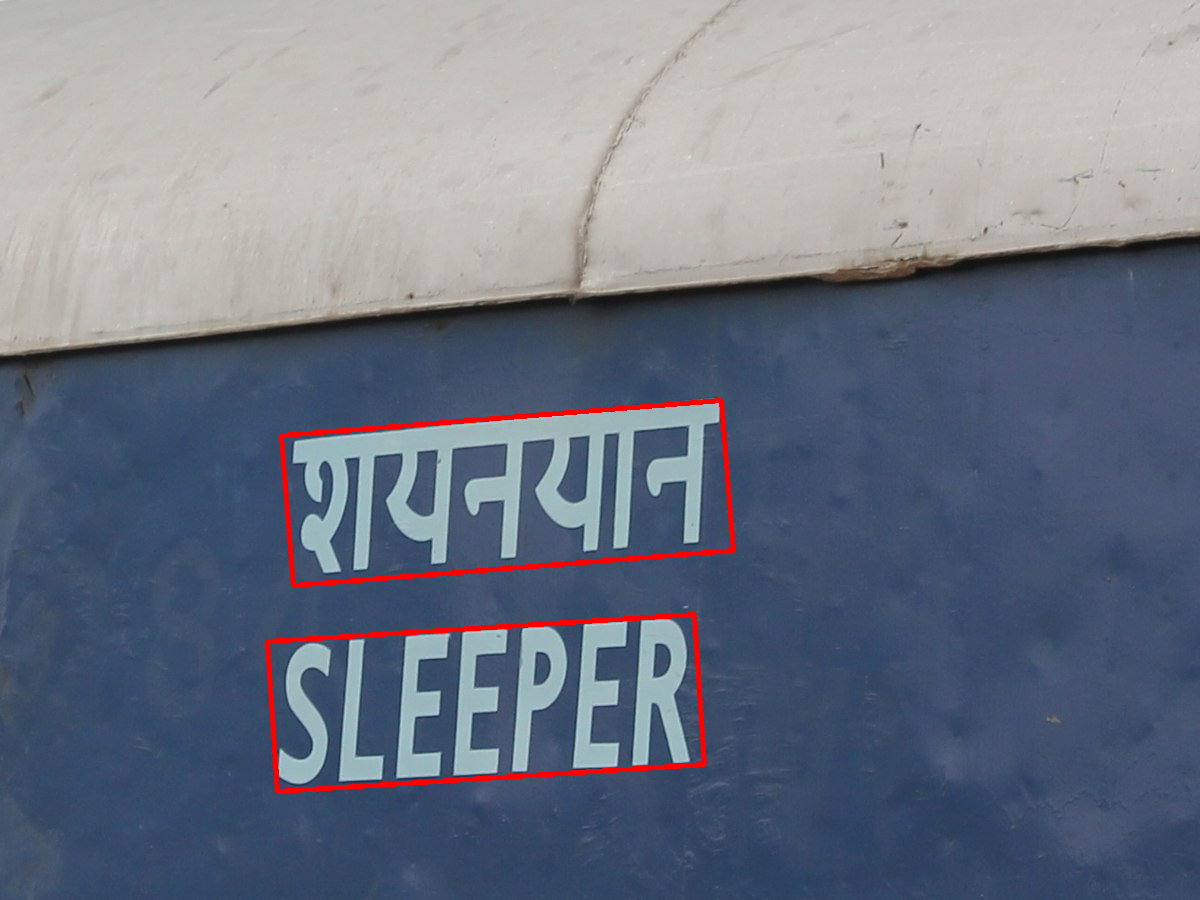

In [ ]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(Image.fromarray(img_pil))

In [ ]:
def recognize_img(input_img, input_img_size=(100,32)):

    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(result_img.astype(np.uint8)))

Result: 	 YRERINT


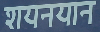

Result: 	 SLEEPER


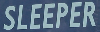

In [ ]:
for _img in cropped_img:
    recognize_img(_img)

## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

유독 에러와의 싸움이 컸던 OCR.. 거기다가 아이펠 노드 자체에서는 경로 문제도 있어서 도중에 가져올때 오류가 끊이질 않아서 더 고생했던 것 같다. 오히려 반대로 데이터가 어마무시하게 커서 들고오는데 시간이 걸렸지 경로 덕분에 코랩 자체에서의 에러가 이어지진 않았다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

LMS 상에서는 1번의 훈련이 예시였고, 그 뒤에는 20번~50번 정도를 고려했었는데 이왕 시간이 걸릴 거 한번에 50번하고 끝내기로 결정했었다. EarlyStopping 덕분에 20번 정도만 했어도 괜찮았겠구나 싶었지만 진짜 예전처럼 순서에 연연하지 않아도 된다는 점이 마음에 놓였다. 다만 학습시간이 오래 걸리기 때문에 피클을 같이 썼어야 시간낭비를 덜했겠구나 싶기도 한데 그래도 끝냈다는거에 의의를 두기로...

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.                                 | 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.                                                        |
| **2** | CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다. | 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.                               |
| **3** | keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.                                    | 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다. |

CRNN 자체가 구현이 까다롭다보니 내가 오롯이 다 구현하기에는 까다로운 면이 있었다. 그래도 충분히 학습이 돼서 그런지 라벨들을 충분히 다 맞출 수 있었다는데서 그래도 목적은 달성한 셈 치기로 했다. 하지만 만약에 이 글자들이 한글일 경우에는 아무래도 장담할 수 없지 않을까 짐작된다.


<br>

#### ▶️ 자기 다짐

저번에도 한번 썼던 OCR이라서 어렵지 않을 줄 알았는데 오히려 반대로 모델이 바뀌어서 그런지 원점으로 돌아온 기분이었다. 하지만 그만큼 RCNN을 다루는 법을 어느정도 알 수 있었던 순간이었다.

<br>

## ✔️Reference(참고자료)
---
* https://meissa.tistory.com/84
* https://d2.naver.com/helloworld/8344782
* https://nanonets.com/blog/deep-learning-ocr/
* https://velog.io/@jarvis_geun/Ubuntu-16.04-OCR-RCNN-V2-%EC%8B%A4%ED%96%89
* https://www.sicara.fr/blog-technique/ocr-text-detection-recognition